# Chapter 7: Compose

## MuseGAN

_MuseGAN_ is a generative machine learning model capable of generating new samples of _multiphonic_ music, i.e. it is capable of composing music with multiple tracks. This is in contrast to the LSTM with an attension mechanism in `AttentionMechanism.ipynb`, which can only generate _monophonic_ music.

MuseGAN, which was introduced in [this paper](https://arxiv.org/abs/1709.06298), like other GANs, consists of a pair of convolutional neural networks, a generator and a critic. The MuseGAN we are building will be generating two new bars of choral music, using music composed by Bach for training.

### MuseGAN Generator

### MuseGAN Critic

## Data Preparation

### Downloading the Data

Here I download the training data from a [this GitHub repository](https://github.com/czhuang/JSB-Chorales-dataset). For this repository I will use a fork of the repository at the time that I am writing this notebook.

In [1]:
!git clone https://github.com/DCtheTall/JSB-Chorales-dataset

Cloning into 'JSB-Chorales-dataset'...
remote: Enumerating objects: 36, done.
remote: Total 36 (delta 0), reused 0 (delta 0), pack-reused 36
Unpacking objects: 100% (36/36), done.


### Preprocessing the Data

The function below outputs the raw data, the data as a 4D tensor in the shape `[n_songs, n_bars, n_steps_per_bar, n_tracks]`. We then one hot encode the data into a 5D tensor of the shape `[n_songs, n_bars, n_steps_per_bar, n_notes, n_tracks]`.

In [0]:
import numpy as np

def load_music(filename, n_bars, n_steps_per_bar):
  """Load the training data into memory and preprocess it."""
  with np.load(filename, encoding='bytes', allow_pickle=True) as f:
    data = f['train']

  data_ints = []
  timesteps = n_bars * n_steps_per_bar
  
  for x in data:
    counter = 0
    while np.any(np.isnan(x[counter:(counter + 4)])):
      counter += 4
    if timesteps < x.shape[0]:
      data_ints.append(x[counter:(counter + timesteps), :])

  data_ints = np.array(data_ints)
  n_songs, _, n_tracks = data_ints.shape
  
  data_ints = data_ints.reshape((n_songs, n_bars, n_steps_per_bar, n_tracks))

  max_note = 83
  where_nans = np.isnan(data_ints)
  data_ints[where_nans] = max_note + 1
  max_note += 1

  data_ints = data_ints.astype(np.int)
  n_classes = max_note + 1

  data_binary = np.eye(n_classes)[data_ints]  # One-hot encode the pitches
  data_binary[data_binary == 0] = -1  # Replace 0s with -1s.
  # Remove the index indicating the last possible pitch. For that pitch, we
  # can just use a row of all -1's.
  data_binary = np.delete(data_binary, max_note, -1)
  data_binary = data_binary.transpose((0, 1, 2, 4, 3))

  return np.squeeze(data_binary), data_ints, data

In [0]:
N_BARS = 2
N_STEPS_PER_BAR = 16

data_binary, data_ints, data = load_music(
    'JSB-Chorales-dataset/Jsb16thSeparated.npz', N_BARS, N_STEPS_PER_BAR)

### Playing the Training Data Music

Let's play some of the training music to get a sense of the style the model is trying to learn.

In [0]:
from music21 import stream, tempo, note, duration, tempo, instrument
import os


def binarise_generator_output(output):
  """Output has the shape [batch_size, bars, steps, pitches, tracks]."""
  return np.argmax(output, axis=3)


def notes_to_midi(output, outdir):
  """Writes output with shape [batch_size, bars, steps, pitches, tracks] to a midi files."""
  batch_size, n_bars, n_steps, n_pitches, n_tracks = output.shape
  for idx in range(batch_size):
    max_pitches = binarise_generator_output(output)
    midi_note_score = max_pitches[idx].reshape([n_bars * n_steps, n_tracks])
    parts = stream.Stream()
    parts.append(tempo.MetronomeMark(number=80))
    for track in range(n_tracks):
      last_x = int(midi_note_score[:,track][0])
      s = stream.Part()
      s.append([instrument.Soprano(),
                instrument.Tenor(),
                instrument.Baritone(),
                instrument.Bass()][track])
      dur = 0.0

      for i, x in enumerate(midi_note_score[:, track]):
        x = int(x)
        if (x != last_x or i % 4 == 0) and i > 0:
          n = note.Note(last_x)
          n.duration = duration.Duration(dur)
          s.append(n)
          dur = 0
        last_x = x
        dur += 0.25
      
      n = note.Note(last_x)
      n.duration = duration.Duration(dur)
      s.append(n)

      parts.append(s)
    parts.write('midi', fp=os.path.join(outdir, '{}.midi'.format(idx)))

In [0]:
notes_to_midi(data_binary[:3], '.')

Convert the music into a .wav file using FluidSynth.

In [0]:
!apt install fluidsynth
!cp /usr/share/sounds/sf2/FluidR3_GM.sf2 ./font.sf2

In [207]:
!fluidsynth -ni font.sf2 0.midi -F 0.wav -r 1000

FluidSynth version 1.1.9
Copyright (C) 2000-2018 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of E-mu Systems, Inc.

Rendering audio to file '0.wav'..


In [208]:
!fluidsynth -ni font.sf2 1.midi -F 1.wav -r 1000

FluidSynth version 1.1.9
Copyright (C) 2000-2018 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of E-mu Systems, Inc.

Rendering audio to file '1.wav'..


In [209]:
!fluidsynth -ni font.sf2 2.midi -F 2.wav -r 1000

FluidSynth version 1.1.9
Copyright (C) 2000-2018 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of E-mu Systems, Inc.

Rendering audio to file '2.wav'..


In [0]:
from IPython.display import Audio
from scipy.io import wavfile

rate, data = wavfile.read('0.wav')
Audio(data.T, rate=rate, autoplay=True)

In [0]:
rate, data = wavfile.read('1.wav')
Audio(data.T, rate=rate, autoplay=True)

In [0]:
rate, data = wavfile.read('2.wav')
Audio(data.T, rate=rate, autoplay=True)

## Implementing MuseGAN

Below is my implementation of MuseGAN based on the implementation in the book's official code repository with some minor modifications. For example, I added some more parameters to the critic model and I have the critic train on 10 batches for each batch we train the generator with.

In [0]:
%tensorflow_version 1.x
from tensorflow.keras.layers import (Input, Conv2DTranspose, BatchNormalization,
                                     Activation, LeakyReLU, Reshape, Lambda,
                                     Dense, Concatenate, Conv3D, Flatten)
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import RandomNormal
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adam, RMSprop
import matplotlib.pyplot as plt


def conv_t(x, filters, kernel_size, strides, padding, kernel_initializer,
           batch_norm_momentum=None, activation='relu'):
  """Returns a convolutional transpose layer for the generator."""
  x = Conv2DTranspose(filters=filters, kernel_size=kernel_size, strides=strides,
                      padding=padding, kernel_initializer=kernel_initializer)(x)
  if batch_norm_momentum:
    x = BatchNormalization(momentum=batch_norm_momentum)(x)
  return LeakyReLU()(x) if activation == 'lrelu' else Activation(activation)(x)


def TemporalNetwork(z_dim, n_bars, kernel_initializer, name):
  """Build a Temporal Network which generates n_bars vectors of shape z_dim."""
  input_layer = Input(shape=(z_dim,))
  x = Reshape([1, 1, z_dim])(input_layer)
  x = conv_t(x, filters=1024, kernel_size=(2, 1), strides=(1, 1),
             activation='relu', batch_norm_momentum=0.9, padding='valid',
             kernel_initializer=kernel_initializer)
  x = conv_t(x, filters=z_dim, kernel_size=(n_bars - 1, 1), strides=(1, 1),
             activation='relu', batch_norm_momentum=0.9, padding='valid',
             kernel_initializer=kernel_initializer)
  output_layer = Reshape([n_bars, z_dim])(x)
  return Model(input_layer, output_layer, name=name)


def BarGenerator(z_dim, n_steps_per_bar, n_pitches, kernel_initializer):
  """Bar Generator expands the time and pitch dimensions of the input."""
  input_layer = Input(shape=(4 * z_dim,))
  x = Dense(1024)(input_layer)
  x = BatchNormalization(momentum=0.9)(x)
  x = Activation('relu')(x)
  x = Reshape([2, 1, 512])(x)
  x = conv_t(x, filters=512, kernel_size=(2, 1), strides=(2, 1), padding='same',
             activation='relu', batch_norm_momentum=0.9,
             kernel_initializer=kernel_initializer)
  x = conv_t(x, filters=256, kernel_size=(2, 1), strides=(2, 1), padding='same',
             activation='relu', batch_norm_momentum=0.9,
             kernel_initializer=kernel_initializer)
  x = conv_t(x, filters=256, kernel_size=(2, 1), strides=(2, 1), padding='same',
             activation='relu', batch_norm_momentum=0.9,
             kernel_initializer=kernel_initializer)
  x = conv_t(x, filters=256, kernel_size=(1, 7), strides=(1, 7), padding='same',
             activation='relu', batch_norm_momentum=0.9,
             kernel_initializer=kernel_initializer)
  x = conv_t(x, filters=1, kernel_size=(1, 12), strides=(1, 12),
             padding='same', activation='tanh',
             kernel_initializer=kernel_initializer)
  output_layer = Reshape([1, n_steps_per_bar, n_pitches, 1])(x)
  return Model(input_layer, output_layer)


def conv(x, filters, kernel_size, strides, padding, kernel_initializer,
         activation='relu'):
  """Creates a 3D convolutional layer for the critic network."""
  x = Conv3D(filters=filters, kernel_size=kernel_size, padding=padding,
             kernel_initializer=kernel_initializer, strides=strides)(x)
  return LeakyReLU()(x) if activation == 'lrelu' else Activation(activation)(x) 


def set_trainable(model, value):
  """Set a model to be trainable or freeze layer weights."""
  model.trainable = value
  for l in model.layers:
    l.trainable = value


def wasserstein_loss(y_true, y_pred):
  """Wasserstein loss function."""
  return -K.mean(y_true * y_pred)


def get_optimizer(optimizer_name, learning_rate):
  """Get an optimizer by name."""
  if optimizer_name == 'adam':
    return Adam(lr=learning_rate, beta_1=0.5, beta_2=0.9)
  if optimizer_name == 'rmsprop':
    return RMSprop(lr=learning_rate)
  return Adam(lr=learning_rate, beta_1=0.5, beta_2=0.9)


class MuseGAN(object):
  """Implementation of MuseGAN with Keras and TensorFlow."""

  def __init__(self, z_dim, n_tracks, n_bars, n_steps_per_bar, n_pitches,
               batch_size, optimizer, critic_learning_rate,
               generator_learning_rate, grad_weight):
    weight_init = RandomNormal(mean=0.0, stddev=0.02)

    # Build the generator.

    chords_input = Input(shape=(z_dim,), name='chords_input')
    style_input = Input(shape=(z_dim,), name='style_input')
    melody_input = Input(shape=(n_tracks, z_dim), name='melody_input')
    groove_input = Input(shape=(n_tracks, z_dim), name='groove_input')

    self.chords_temp_network = TemporalNetwork(z_dim, n_bars, weight_init,
                                               'temporal_network')
    # Ouput shape is [?, n_bars, z_dim]
    chords_output = self.chords_temp_network(chords_input)

    melody_temp_networks = [None] * n_tracks
    # Output shape will be [n_tracks, ?, n_bars, z_dim]
    melody_outputs = [None] * n_tracks
    for track in range(n_tracks):
      melody_temp_networks[track] = TemporalNetwork(z_dim, n_bars, weight_init,
                                                    'melody_{}'.format(track))
      temp_network_input = Lambda(lambda x: x[:, track, :])(melody_input)
      melody_outputs[track] = melody_temp_networks[track](temp_network_input)

    self.bar_gen = [None] * n_tracks
    for track in range(n_tracks):
      self.bar_gen[track] = BarGenerator(z_dim, n_steps_per_bar, n_pitches,
                                         weight_init)
    
    # Output shape will be [n_bars, ?, 1, n_steps_per_bar, n_pitches, n_tracks]
    bars_output = [None] * n_bars
    for bar in range(n_bars):
      track_output = [None] * n_tracks
      c = Lambda(lambda x: x[:, bar, :])(chords_output)
      s = style_input
      for track in range(n_tracks):
        m = Lambda(lambda x: x[:, bar, :])(melody_outputs[track])
        g = Lambda(lambda x: x[:, track, :])(groove_input)
        z_input = Concatenate(axis=1)([c, s, m, g])
        track_output[track] = self.bar_gen[track](z_input)
      bars_output[bar] = Concatenate(axis=-1)(track_output)
    
    generator_output = Concatenate(axis=1)(bars_output)
    self.generator = Model(
        [chords_input, style_input, melody_input, groove_input],
        generator_output)
    
    # Build the critic.

    critic_input = Input(shape=(n_bars, n_steps_per_bar, n_pitches, n_tracks))
    x = critic_input
    x = conv(x, filters=128, kernel_size=(2, 1, 1), strides=(1, 1, 1),
             activation='lrelu', padding='valid',
             kernel_initializer=weight_init)
    x = conv(x, filters=128, kernel_size=(n_bars - 1, 1, 1), strides=(1, 1, 1),
             activation='lrelu', padding='valid',
             kernel_initializer=weight_init)
    
    x = conv(x, filters=128, kernel_size=(1, 1, 12), strides=(1, 1, 12),
             activation='lrelu', padding='same', kernel_initializer=weight_init)
    x = conv(x, filters=256, kernel_size=(1, 1, 7), strides=(1, 1, 7),
             activation='lrelu', padding='same', kernel_initializer=weight_init)
    x = conv(x, filters=256, kernel_size=(1, 2, 1), strides=(1, 2, 1),
             activation='lrelu', padding='same', kernel_initializer=weight_init)
    x = conv(x, filters=256, kernel_size=(1, 2, 1), strides=(1, 2, 1),
             activation='lrelu', padding='same', kernel_initializer=weight_init)
    x = conv(x, filters=256, kernel_size=(1, 4, 1), strides=(1, 2, 1),
             activation='lrelu', padding='same', kernel_initializer=weight_init)
    x = conv(x, filters=512, kernel_size=(1, 3, 1), strides=(1, 2, 1),
             activation='lrelu', padding='same', kernel_initializer=weight_init)
    
    x = Flatten()(x)
    x = Dense(1024, kernel_initializer=weight_init)(x)
    x = LeakyReLU()(x)
    critic_output = Dense(1, activation=None, kernel_initializer=weight_init)(x)

    self.critic = Model(critic_input, critic_output)

    # Build the computational graph for the critic.
    set_trainable(self.generator, False)
    set_trainable(self.critic, True)

    real_img = Input(shape=(n_bars, n_steps_per_bar, n_pitches, n_tracks))
    chords_input = Input(shape=(z_dim,))
    style_input = Input(shape=(z_dim,))
    melody_input = Input(shape=(n_tracks, z_dim))
    groove_input = Input(shape=(n_tracks, z_dim))

    fake_img = self.generator(
        [chords_input, style_input, melody_input, groove_input])
    
    fake = self.critic(fake_img)
    real = self.critic(real_img)

    def interpolate_inputs(inputs):
      alpha = K.random_uniform((batch_size, 1, 1, 1, 1))
      return (alpha * inputs[0]) + ((1 - alpha) * inputs[1])

    self.interpolated_img = Lambda(interpolate_inputs)([fake_img, real_img])
    interpolated_pred = self.critic(self.interpolated_img)

    self.critic_model = Model(inputs=[real_img, chords_input, style_input,
                                      melody_input, groove_input],
                              outputs=[real, fake, interpolated_pred])
    self.critic_model.compile(
        loss=[wasserstein_loss, wasserstein_loss, self.gradient_penalty_loss],
        optimizer=get_optimizer(optimizer, critic_learning_rate),
        loss_weights=[1, 1, grad_weight])
    
    # Build the computational graph for the generator.
    set_trainable(self.generator, True)
    set_trainable(self.critic, False)

    chords_input = Input(shape=(z_dim,))
    style_input = Input(shape=(z_dim,))
    melody_input = Input(shape=(n_tracks, z_dim))
    groove_input = Input(shape=(n_tracks, z_dim))

    set_trainable(self.critic, True)

    img = self.generator(
        [chords_input, style_input, melody_input, groove_input])
    model_output = self.critic(img)
    self.model = Model(
        [chords_input, style_input, melody_input, groove_input], model_output)
    self.model.compile(loss=wasserstein_loss,
                       optimizer=get_optimizer(
                           optimizer, generator_learning_rate))
    
    self.z_dim = z_dim
    self.n_tracks = n_tracks
    self.batch_size = batch_size
    self.n_bars = n_bars

  def gradient_penalty_loss(self, y_true, y_pred):
    """Compute the GP loss using interpolations of real and fake images."""
    gradients = K.gradients(y_pred, self.interpolated_img)[0]
    assert gradients is not None
    gradients_sqr = K.square(gradients)
    gradients_l2_norm = K.sqrt(
        K.sum(gradients_sqr, axis=np.arange(1, len(gradients_sqr.shape))))
    return K.mean(K.square(1 - gradients_l2_norm))

  def train_critic(self, X_train):
    """Train the critic with a single training batch."""
    batch_size = self.batch_size
    real = np.ones((batch_size, 1), dtype=np.float32)
    fake = -np.ones((batch_size, 1), dtype=np.float32)
    real_imgs = X_train[np.random.randint(0, X_train.shape[0], self.batch_size)]

    chords_noise = np.random.normal(0, 1, (batch_size, self.z_dim))
    style_noise = np.random.normal(0, 1, (batch_size, self.z_dim))
    melody_noise = np.random.normal(
        0, 1, (batch_size, self.n_tracks, self.z_dim))
    groove_noise = np.random.normal(
        0, 1, (batch_size, self.n_tracks, self.z_dim))
    
    return self.critic_model.train_on_batch(
        [real_imgs, chords_noise, style_noise, melody_noise, groove_noise],
        [real, fake, np.zeros((batch_size, 1), dtype=np.float32)])
    
  def train_generator(self):
    """Train the generator with a single training batch."""
    batch_size = self.batch_size
    real = np.ones((batch_size, 1), dtype=np.float32)
    chords_noise = np.random.normal(0, 1, (batch_size, self.z_dim))
    style_noise = np.random.normal(0, 1, (batch_size, self.z_dim))
    melody_noise = np.random.normal(
        0, 1, (batch_size, self.n_tracks, self.z_dim))
    groove_noise = np.random.normal(
        0, 1, (batch_size, self.n_tracks, self.z_dim))
    return self.model.train_on_batch(
        [chords_noise, style_noise, melody_noise, groove_noise], real)
    
  def train(self, X_train, epochs, checkpoint_dir, save_every_n_epochs=1,
            initial_epoch=0, n_critic=5):
    """Run the training loop."""
    if initial_epoch > 0:
      self.model.load_weights(
          os.path.join(checkpoint_dir, 'weights-{}.hdf5'.format(initial_epoch)))
    for epoch in range(initial_epoch + 1, epochs + 1):
      for _ in range(n_critic):
        d_loss = self.train_critic(X_train)
      g_loss = self.train_generator()
      if epoch % save_every_n_epochs == 0:
        print('Saving model weights after epoch: {}'.format(epoch))
        print('D loss: (R {:.2f} F {:.2f} GP {:.2f}) G loss: {:.2f}'.format(
            *d_loss, g_loss))
        self.model.save_weights(checkpoint_dir + 'weights.hdf5')
        self.model.save_weights(
            checkpoint_dir + 'weights-{}.hdf5'.format(epoch))
        
  def draw_score(self, gen_score):
    """Draw the generated score as a sequence of pitches."""
    fig, axes = plt.subplots(ncols=len(gen_score) * self.n_bars,
                             nrows=self.n_tracks,
                             figsize=(12 * len(gen_score), 8),
                             sharex=True, sharey=True)
    fig.subplots_adjust(0, 0, 0.2, 1.5, 0, 0)
    for idx, score in enumerate(gen_score):
      for bar in range(self.n_bars):
        for track in range(self.n_tracks):
          if self.n_bars > 1:
            axes[track, bar + (idx * self.n_bars)].imshow(
                score[bar, :, :, track].transpose([1, 0]),
                origin='lower', cmap='Greys', vmin=-1, vmax=1)
          else:
            axes[(idx * self.n_bars) + track].imshow(
                score[bar, :, :, track].transpose([1, 0]),
                origin='lower', cmap='Greys', vmin=-1, vmax=1)

In [0]:
Z_DIM = 32
N_TRACKS = 4
N_PITCHES = 84
BATCH_SIZE = 64
LEARNING_RATE = 0.001

gan = MuseGAN(z_dim=Z_DIM, 
              n_tracks=N_TRACKS,
              n_bars=N_BARS,
              n_steps_per_bar=N_STEPS_PER_BAR,
              n_pitches=N_PITCHES,
              batch_size=BATCH_SIZE,
              optimizer='adam',
              grad_weight=10,
              critic_learning_rate=LEARNING_RATE,
              generator_learning_rate=LEARNING_RATE)

In [24]:
gan.generator.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
melody_input (InputLayer)       [(None, 4, 32)]      0                                            
__________________________________________________________________________________________________
chords_input (InputLayer)       [(None, 32)]         0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 32)           0           melody_input[0][0]               
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 32)           0           melody_input[0][0]               
____________________________________________________________________________________________

In [250]:
gan.critic.summary()

Model: "model_45"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_105 (InputLayer)       [(None, 2, 16, 84, 4)]    0         
_________________________________________________________________
conv3d_40 (Conv3D)           multiple                  1152      
_________________________________________________________________
leaky_re_lu_45 (LeakyReLU)   multiple                  0         
_________________________________________________________________
conv3d_41 (Conv3D)           multiple                  16512     
_________________________________________________________________
leaky_re_lu_46 (LeakyReLU)   multiple                  0         
_________________________________________________________________
conv3d_42 (Conv3D)           multiple                  196736    
_________________________________________________________________
leaky_re_lu_47 (LeakyReLU)   multiple                  0  

## Training the Model

Below we train the model for 6,000 training batches.

In [0]:
# Mount Google drive to load the data and to save the model weights.
from google.colab import drive

drive.mount('/content/gdrive/')
checkpoint_dir = '/content/gdrive/My Drive/gdl_models/musegan/'

In [0]:
!mkdir -p "/content/gdrive/My Drive/gdl_models/musegan/"

In [0]:
EPOCHS = 10000

gan.train(data_binary,
          epochs=EPOCHS,
          checkpoint_dir=checkpoint_dir,
          save_every_n_epochs=50,
          initial_epoch=6000,
          n_critic=10)

## Analyzing the Results

In [0]:
gan.model.load_weights(checkpoint_dir + 'weights-6000.hdf5')

In [0]:
chords_noise = np.random.normal(0, 1, (1, gan.z_dim))
style_noise = np.random.normal(0, 1, (1, gan.z_dim))
melody_noise = np.random.normal(0, 1, (1, gan.n_tracks, gan.z_dim))
groove_noise = np.random.normal(0, 1, (1, gan.n_tracks, gan.z_dim))

gen_scores = gan.generator.predict(
    [chords_noise, style_noise, melody_noise, groove_noise])

In [440]:
gen_scores.shape

(1, 2, 16, 84, 4)

In [459]:
np.argmax(gen_scores[0, 0, 0:16, :, 3], axis=1)

array([41, 41, 43, 43, 57, 57, 57, 57, 48, 48, 48, 48, 50, 50, 50, 50])

In [0]:
!mkdir -p pred

In [0]:
notes_to_midi(gen_scores, 'pred')

In [461]:
!fluidsynth -ni font.sf2 pred/0.midi -F pred/0.wav -r 1000

FluidSynth version 1.1.9
Copyright (C) 2000-2018 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of E-mu Systems, Inc.

Rendering audio to file 'pred/0.wav'..


In [0]:
rate, data = wavfile.read('pred/0.wav')
Audio(data.T, rate=rate, autoplay=True)

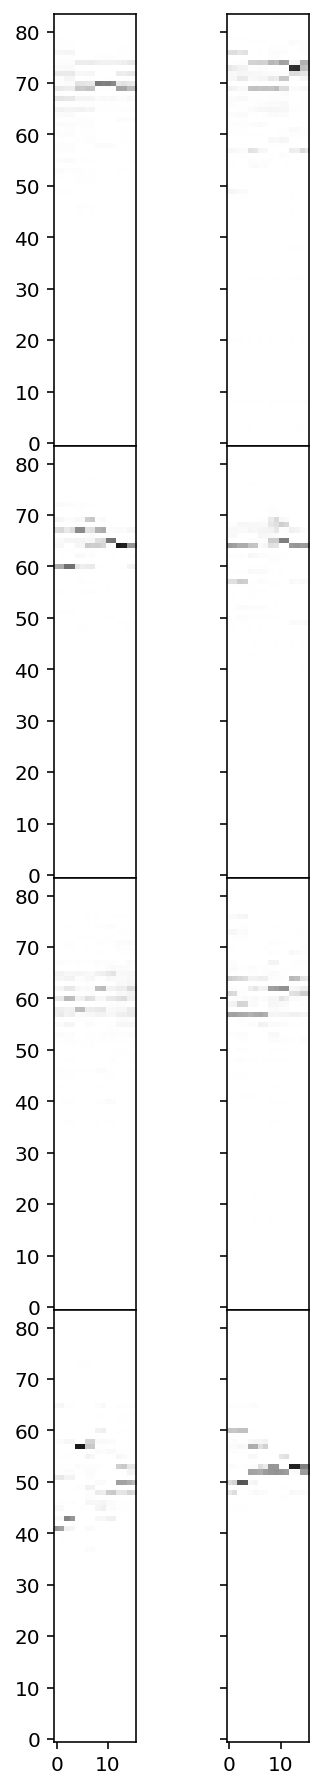

In [463]:
gan.draw_score(gen_scores)

Now let's try the same input but change the chords noise.

In [0]:
!mkdir -p pred_c

In [0]:
chords_noise2 = np.random.normal(0, 1, (1, gan.z_dim))
gen_scores_c = gan.generator.predict(
    [chords_noise2, style_noise, melody_noise, groove_noise])

In [0]:
notes_to_midi(gen_scores_c, 'pred_c')

In [467]:
!fluidsynth -ni font.sf2 pred_c/0.midi -F pred_c/0.wav -r 1000

FluidSynth version 1.1.9
Copyright (C) 2000-2018 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of E-mu Systems, Inc.

Rendering audio to file 'pred_c/0.wav'..


Let's compare the audio.

In [0]:
rate, data = wavfile.read('pred/0.wav')
Audio(data.T, rate=rate, autoplay=True)

In [0]:
rate, data = wavfile.read('pred_c/0.wav')
Audio(data.T, rate=rate, autoplay=True)

And let's compare the scores side by side. The original is on the left and the score with the new chords input is on the right.

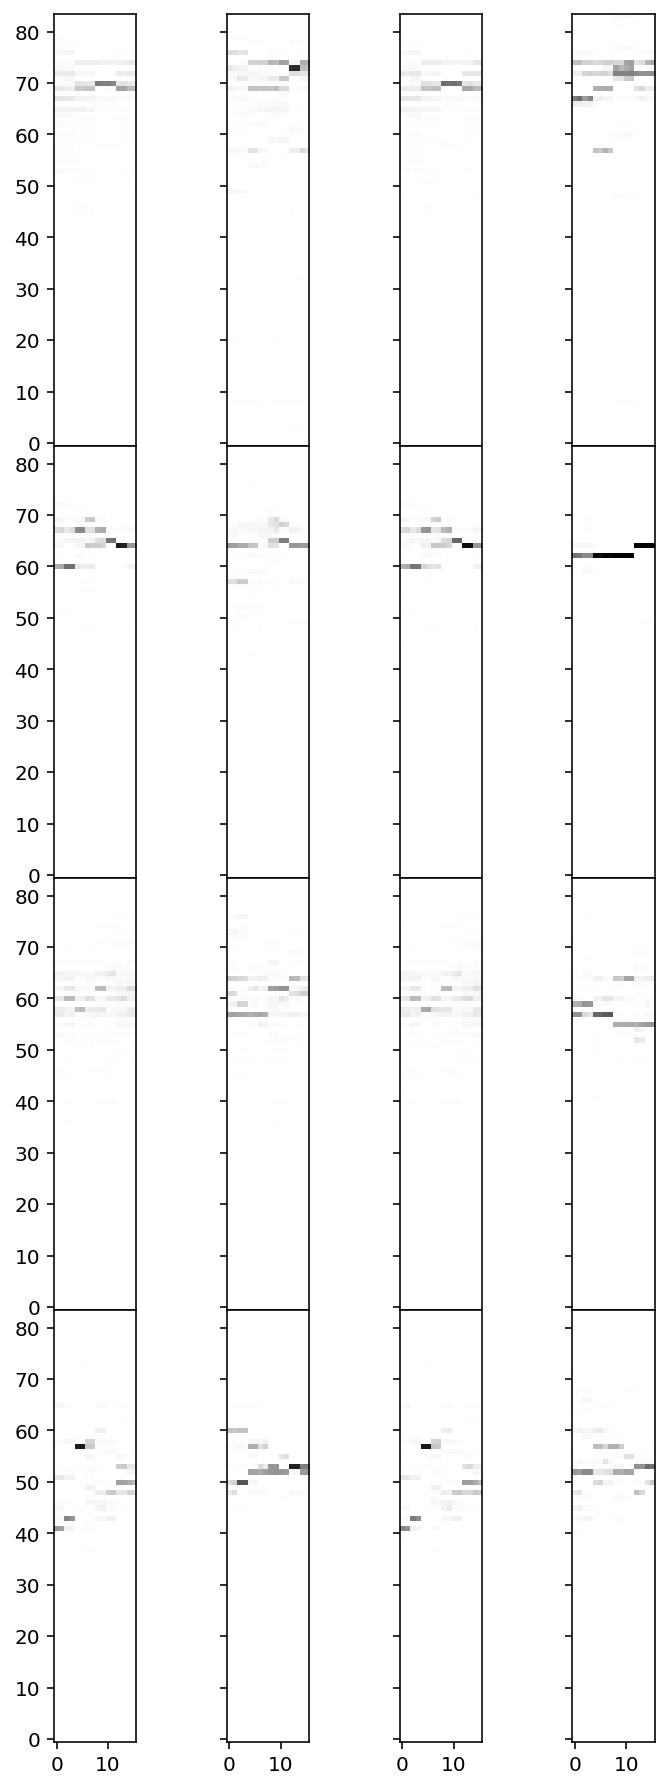

In [470]:
gan.draw_score(np.array([gen_scores[0], gen_scores_c[0]]))

Similarly, let's try changing the style noise.

In [0]:
!mkdir -p pred_s

In [0]:
style_noise2 = np.random.normal(0, 1, (1, gan.z_dim))
gen_scores_s = gan.generator.predict(
    [chords_noise, style_noise2, melody_noise, groove_noise])

In [0]:
notes_to_midi(gen_scores_s, 'pred_s')

In [478]:
!fluidsynth -ni font.sf2 pred_s/0.midi -F pred_s/0.wav -r 1000

FluidSynth version 1.1.9
Copyright (C) 2000-2018 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of E-mu Systems, Inc.

Rendering audio to file 'pred_s/0.wav'..


In [0]:
rate, data = wavfile.read('pred/0.wav')
Audio(data.T, rate=rate, autoplay=True)

In [0]:
rate, data = wavfile.read('pred_s/0.wav')
Audio(data.T, rate=rate, autoplay=True)

The original is on the left and the score with the new style input is on the right.

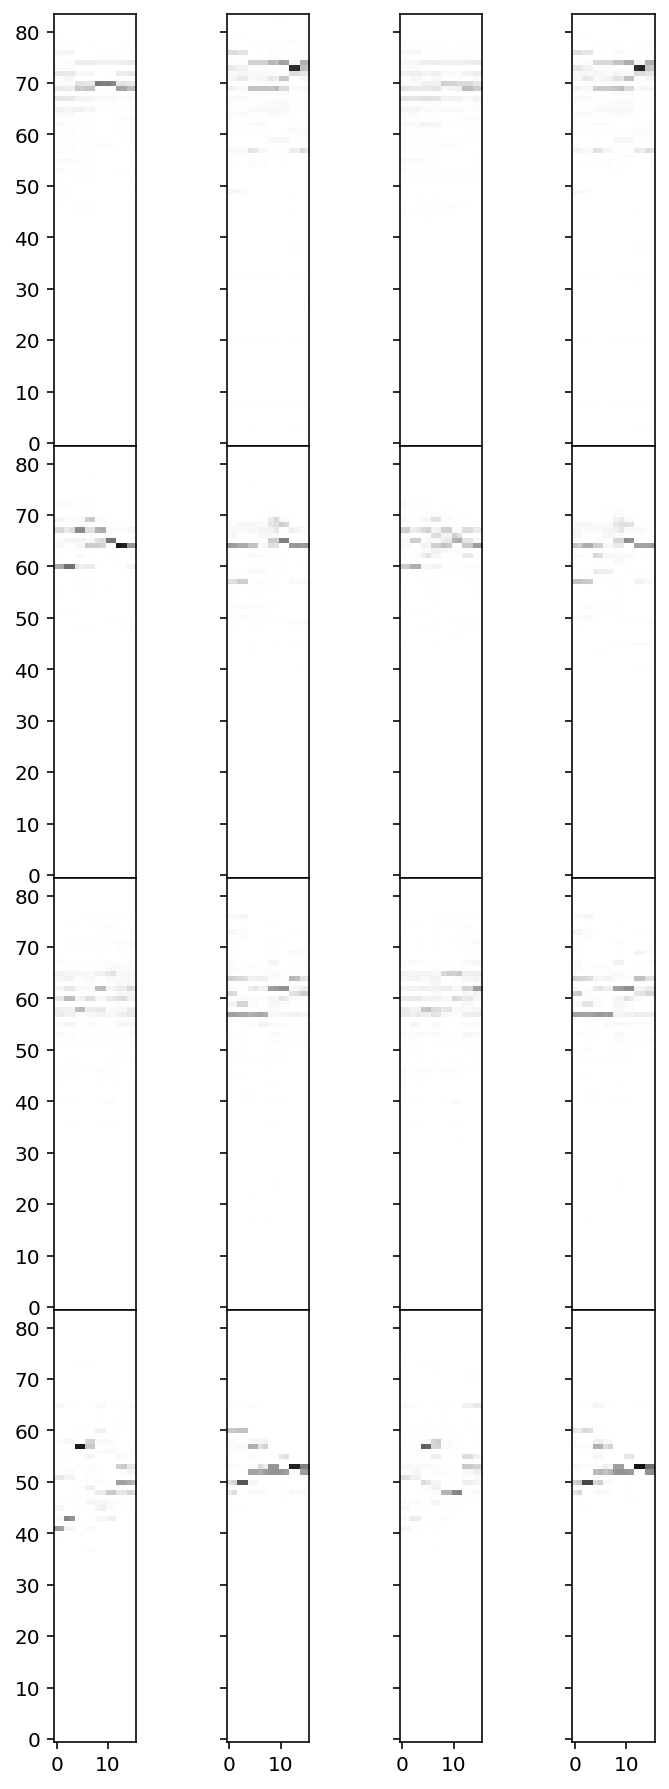

In [480]:
gan.draw_score(np.array([gen_scores[0], gen_scores_s[0]]))

Now we modify the melody noise.

In [0]:
melody_noise2 = np.random.normal(0, 1, (1, gan.n_tracks, gan.z_dim))

gen_scores_m = gan.generator.predict(
    [chords_noise, style_noise, melody_noise2, groove_noise])

In [0]:
!mkdir -p pred_m

In [0]:
notes_to_midi(gen_scores_m, 'pred_m')

In [484]:
!fluidsynth -ni font.sf2 pred_m/0.midi -F pred_m/0.wav -r 1000

FluidSynth version 1.1.9
Copyright (C) 2000-2018 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of E-mu Systems, Inc.

Rendering audio to file 'pred_m/0.wav'..


In [0]:
rate, data = wavfile.read('pred/0.wav')
Audio(data.T, rate=rate, autoplay=True)

In [0]:
rate, data = wavfile.read('pred_m/0.wav')
Audio(data.T, rate=rate, autoplay=True)

The original is on the left and the score with the new melody input is on the right.

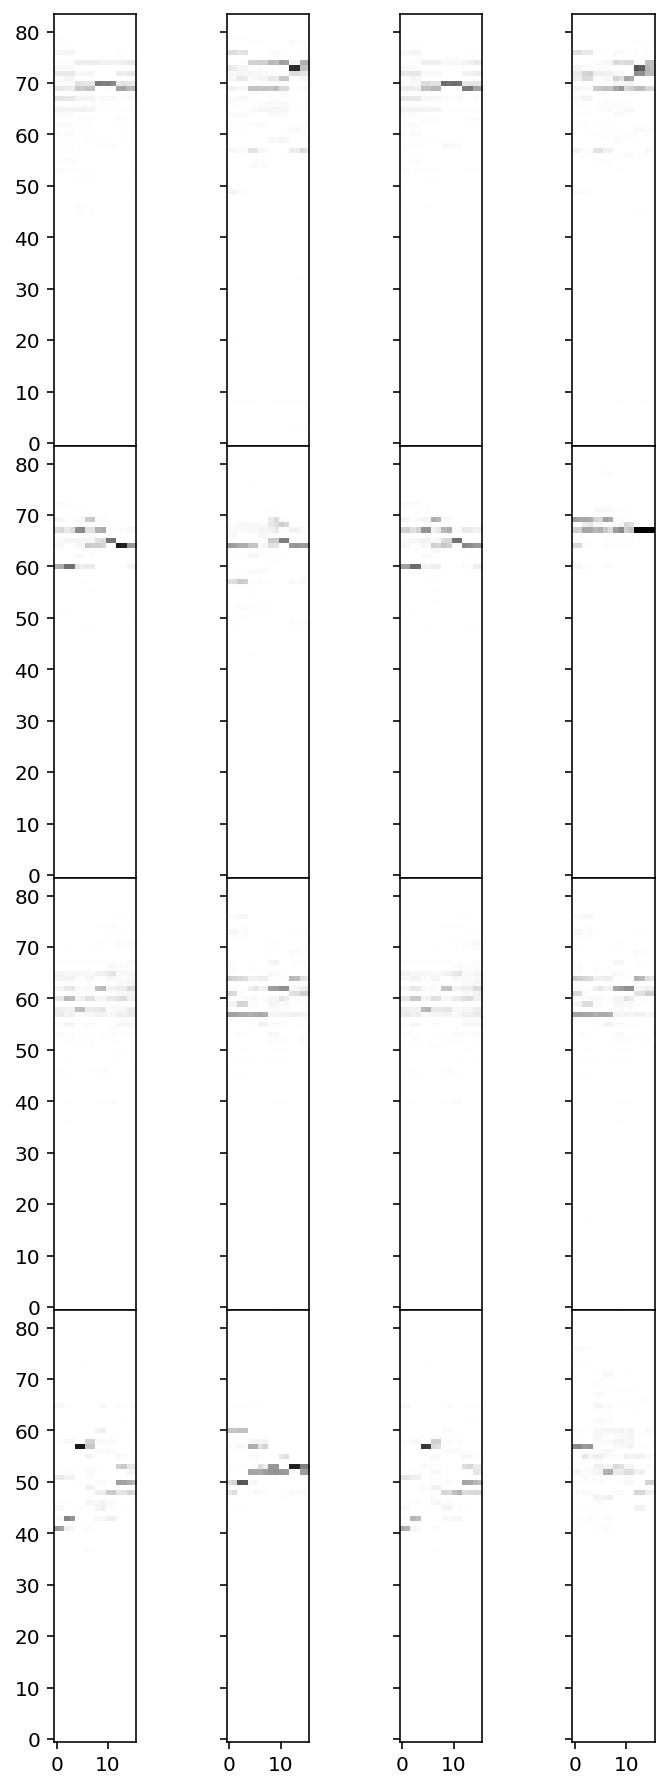

In [488]:
gan.draw_score(np.array([gen_scores[0], gen_scores_m[0]]))

Finally, we try generating the same music using a new groove vector.

In [0]:
groove_noise2 = np.random.normal(0, 1, (1, gan.n_tracks, gan.z_dim))

gen_scores_g = gan.generator.predict(
    [chords_noise, style_noise, melody_noise, groove_noise2])

In [0]:
!mkdir -p pred_g

In [0]:
notes_to_midi(gen_scores_g, 'pred_g')

In [498]:
!fluidsynth -ni font.sf2 pred_g/0.midi -F pred_g/0.wav -r 1000

FluidSynth version 1.1.9
Copyright (C) 2000-2018 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of E-mu Systems, Inc.

Rendering audio to file 'pred_g/0.wav'..


In [0]:
rate, data = wavfile.read('pred/0.wav')
Audio(data.T, rate=rate, autoplay=True)

In [0]:
rate, data = wavfile.read('pred_g/0.wav')
Audio(data.T, rate=rate, autoplay=True)

The original is on the left and the score with the new groove input is on the right.

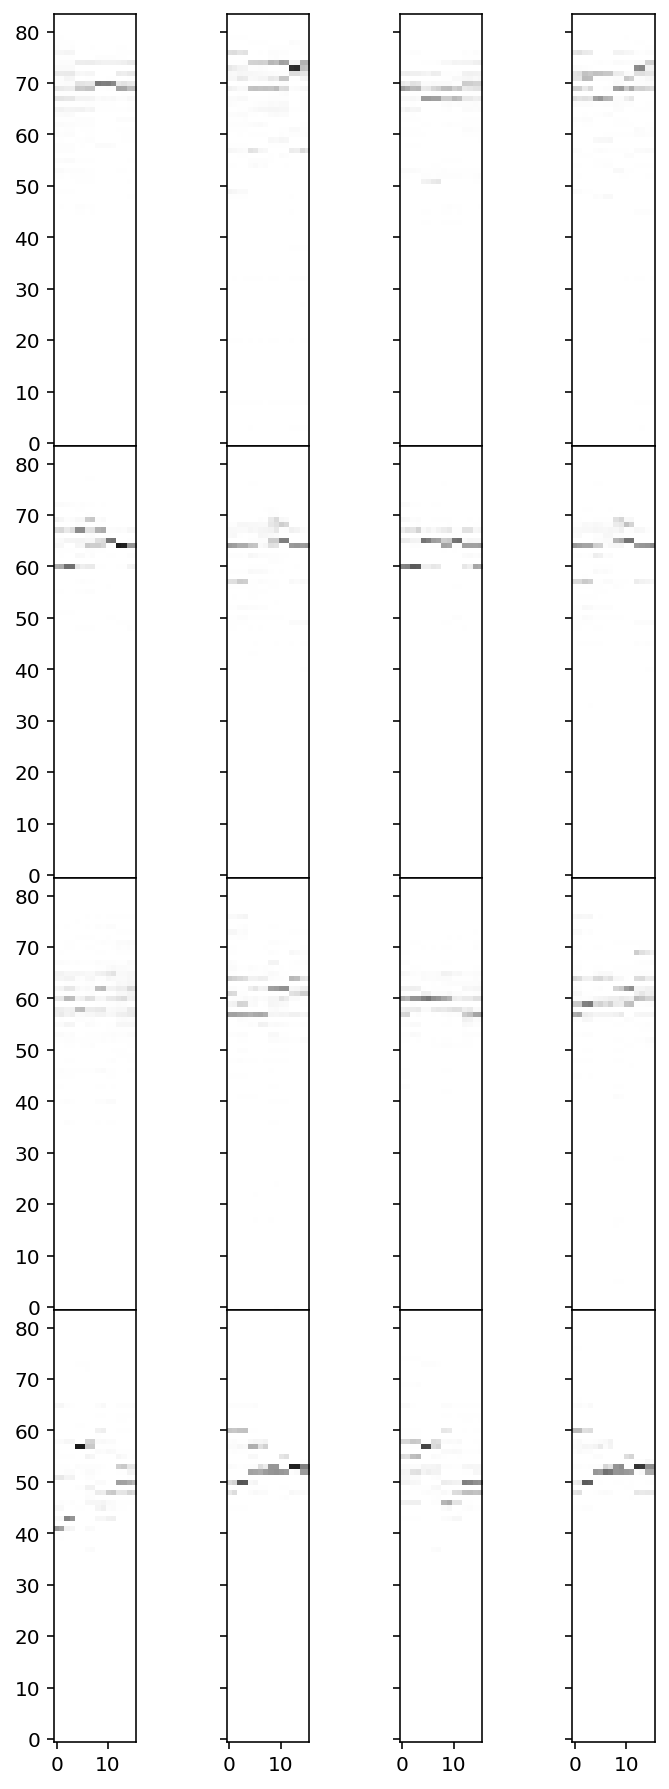

In [500]:
gan.draw_score(np.array([gen_scores[0], gen_scores_g[0]]))